# Full images to patches

In [1]:
import torch
import random
from datetime import datetime
import PIL

from tqdm import tqdm_notebook as tqdm

In [2]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [3]:
from dataset import *
from show import *
from utils import *
from constants import *
from augmentation import *

In [ ]:
def create_path(name, idx, ext):
    return '/data/images/original/{}_{:03d}.{}'.format(name, idx, ext)

In [4]:
img_dir = '{}/labels'.format(path_to_data)
img_paths = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir))]

In [40]:
def get_img_lbl(i, from_torch=False):
    if from_torch:
        return tuple_to_pil(torch.load(create_path('img', i, 'torch')), torch.load(create_path('lbl', i, 'torch')))
    else:
        return load_png_tuple('{}/images/original'.format(path_to_data), i)

def get_patches(i, ncrops_multiplier=1, as_tensor=True):
    return aug_pipeline(*get_img_lbl(i), ncrops_multiplier=ncrops_multiplier, as_tensor=as_tensor)

In [41]:
images_labels = list(get_img_lbl(i) for i in range(num_images))

In [49]:
img, lbl = get_img_lbl(0)
img, lbl = T.ToTensor()(img), (T.ToTensor()(lbl)*255).int()

(2048, 3072, 3) (2048, 3072, 1)


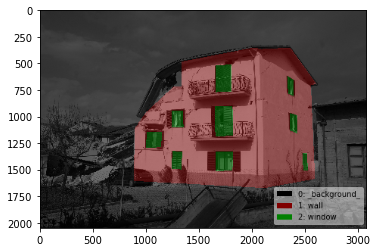

In [50]:
show_labeled_img(img, lbl, label_name_to_value)

## full-res image to 2 rotations
One with angle [-10, -5] and one with [5, 10]

Cropped such that it does not include black borders

In [52]:
img_2_rot = gen_2_rot(img, lbl)

In [53]:
i0, l0 = img_2_rot[1][0], img_2_rot[1][1]

(1578, 2841, 3) (1578, 2841, 1)


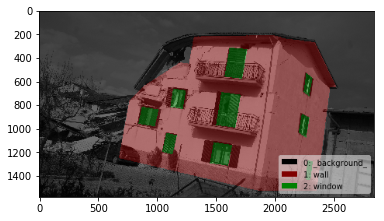

In [54]:
show_labeled_img(i0, l0, label_name_to_value)

## full-res image without useless borders

In [55]:
i1, l1 = cut_borders(i0, l0)

(1478, 2061, 3) (1478, 2061, 1)


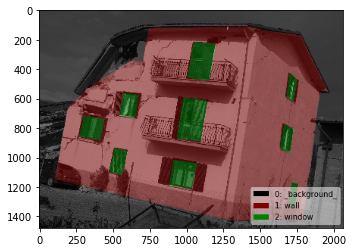

In [56]:
show_labeled_img(i1, l1, label_name_to_value)

## full-res image to crops

In [57]:
w,h = l1.shape[1:]
crop_size = min(w, h) // 3
ncrops = round(0.5 * w/crop_size * h/crop_size)
ncrops

6

In [58]:
crops = gen_crops(i1, l1, crop_size, ncrops)
len(crops)

6

(256, 256, 3) (256, 256, 1)


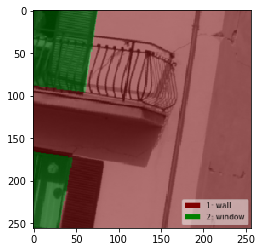

In [69]:
show_labeled_img(*crops[0], label_name_to_value)

## crops tranformations

### horizontal flips

(256, 256, 3) (256, 256, 1)


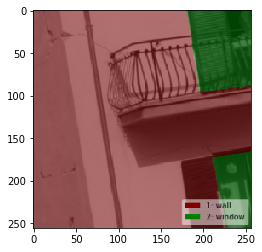

In [70]:
show_labeled_img(*random_flip(*crops[0], p=1), label_name_to_value)

### brightness + noise + grayscale + ... ?

torch.Size([1582, 5688, 3])


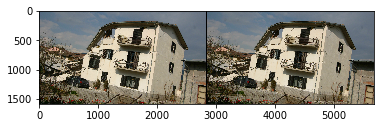

In [71]:
show_img(make_grid([i0, random_brightness(i0, l0)[0]]))

## Whole pipeline

In [74]:
img = Image.open('/data/images/original/img_000.png')
lbl = Image.open('/data/images/original/lbl_000.png')

In [75]:
img_patches, lbl_patches = aug_pipeline(img, lbl)

torch.Size([1550, 776, 3])


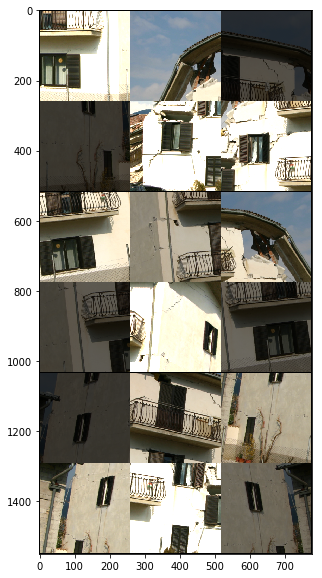

In [78]:
plt.figure(figsize=(20, 10))
show_img(make_grid(img_patches, nrow=3))

torch.Size([776, 1550, 1])


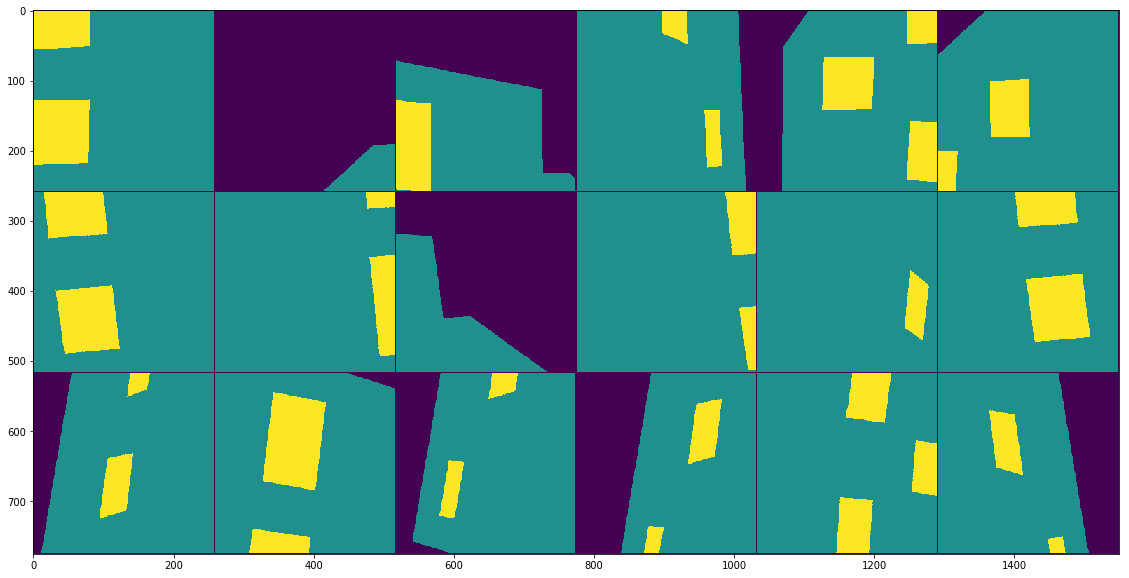

In [77]:
plt.figure(figsize=(20, 10))
show_img(make_grid(lbl_patches, nrow=6)[0:1, :, :])

# Generate rotations with cropped borders

In [6]:
def load_sample(img_idx, rot_idx):
    def load(s):
        return torch.load('{}/images/rot_aug_{}/{}_{:03d}_{:03d}.torch'.format(path_to_data, max_size, s, img_idx, rot_idx))
    return load('img'), load('lbl')

In [7]:
%timeit load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1))

The slowest run took 6.79 times longer than the fastest. This could mean that an intermediate result is being cached.
125 ms ± 60.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


torch.Size([819, 1024, 3])


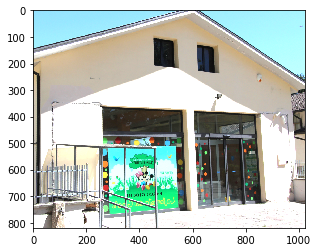

In [8]:
show_img(load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1))[0])

In [9]:
def random_crop(img, lbl, crop_size=patch_size):
    assert type(img) is torch.Tensor
    
    h,w = img.shape[1:]
    top = random.randint(0, h-patch_size-1)
    left = random.randint(0, w-patch_size-1)
    return img[:, top:top+patch_size, left:left+patch_size],\
            lbl[:, top:top+patch_size, left:left+patch_size]

In [10]:
%timeit random_crop(*load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1)))

The slowest run took 39.67 times longer than the fastest. This could mean that an intermediate result is being cached.
81.9 ms ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


torch.Size([256, 256, 3])


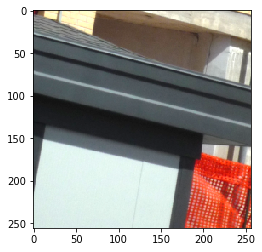

In [11]:
show_img(random_crop(*load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1)))[0])

(256, 256, 3) (256, 256, 1)


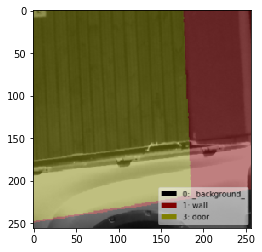

In [12]:
show_labeled_img(*random_crop(*load_sample(random.randint(0, num_images-1),random.randint(0, num_rotations-1))))